In [58]:
import pandas as pd
import numpy.ma as ma
import numpy
import pickle
import time
import joblib
import gensim
import matplotlib.pyplot as plt

from itertools import islice
from scipy.linalg import block_diag
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity

In [59]:
# Remove warnings
import warnings
warnings.filterwarnings("ignore")

In [60]:
# Function to compute the corpus and dictionary for the DTM LDA
def createLDAvars(docs):

    # Create the variables needed for LDA from df[final_frqwds_removed]: dictionary (id2word), corpus
    
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(docs)

    #Filter words to only those found in at least a set number of documents (min_appearances)
    id2word.filter_extremes(no_below=20, no_above=0.6)
    
    # filter out stop words - "use" already filtered out by previous line
    id2word.filter_tokens(bad_ids=[id2word.token2id['research'], id2word.token2id['project']])

    # Create Corpus (Term Document Frequency)

    #Creates a count for each unique word appearing in the document, where the word_id is substituted for the word
    # corpus not need for c_v coherence
    corpus = [id2word.doc2bow(doc) for doc in docs]

    return id2word, corpus


# Modify the pre-processing function
def preprocess(df, stopwords):
    # Append all the final tokens
    text = []
    docs = df['final_tokens01']
    
    for abstract in docs:
        text.append(' '.join(abstract))
        
    # Create the term-document matrix
    tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=0, lowercase=False, stop_words=stop_wds)
    tf_idf = tfidf_vectorizer.fit_transform(text)
            
    return (tf_idf, tfidf_vectorizer)


# function modified from https://nlpforhackers.io/topic-modeling/
def list_topics(topic_term_dist, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.  
    topic_words = []
    
    for idx, topic in enumerate(topic_term_dist):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1: 
            # check if the vectorized has an attribute get_features_names. if not vectorized contains terms hasattr('abc', 'lower')
            if hasattr(vectorizer, 'get_feature_names'):
                topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
            else:
                topic_words.append([vectorizer[i] for i in topic.argsort()[::-1]])
        else:
            if hasattr(vectorizer, 'get_feature_names'):
                topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
            else:
                topic_words.append([vectorizer[i] for i in topic.argsort()[:-top_n - 1:-1]])
        
    return topic_words



# function adapted from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
def nmf_models(doc_term_matrix, n_topics, vectorizer, rand_start):
    """
    Compute NMF model, save topics list for coherence calc
    Parameters:
    ----------
    tf_idf
    n_topics : list of number of topics
    """
    
    nmf_time = []
    topics_list = []
    W_list = []
    H_list = []
    
    i = rand_start
    for num_topics in n_topics:

        # create model
        t1 = time.time()
        nmf_model = NMF(n_components=num_topics, random_state = i)
        nmf_model.fit_transform(doc_term_matrix)
        t2 = time.time()
        nmf_time.append(t2-t1)
        #print(f"  Model time: {t2-t1}", flush=True)
        
        # create list of topics
        topics = list_topics(nmf_model.components_, vectorizer, top_n=10)
        topics_list.append(topics)
        
        # output completion message
        i = i+1
        #print('Number of topics =', num_topics, "complete.", flush=True)
        
        # save the matrix W and H
        W = nmf_model.fit_transform(doc_term_matrix)
        W_list.append(W)
        H = nmf_model.components_
        
        # truncate the H matrix: set the weight of the non top n words to zero
        #top_n = 10
        #for idx, topic in enumerate(H):
        #    thresold = numpy.nanmin(topic[topic.argsort()[:-top_n-1:-1]])
        #    topic[topic<thresold]=0  
        H_list.append(H)

    return nmf_time, topics_list, W_list, H_list


# solve an nmf model for each windows topic
def first_stage(path, year, n_topics, dictionary, docs):
    """
    Solve a dynamic nmf for each fiscal year
    Parameters:
    ----------
    path : location of term-document matrix
    year : list of fiscal year
    n_topics : list of number of topics
    dictionary : dictionary of terms
    docs : corpus
    """
    batch = 7
    
    windows_coherence = []
    windows_topic_list = []
    windows_topic = []
    windows_W = []
    windows_H = []
    windows_terms = []
    
    # Run the dynamic nmf for each fiscal year
    for y in year:
        # Load the document-term matrix
        (tf_idf,tfidf_vectorizer,df) = joblib.load( path+str(y)+'.pkl' )
    
        # Solve an nmf model for a given range of topics
        (nmf_time,topics_list,W_list,H_list) = nmf_models(doc_term_matrix=tf_idf, n_topics=n_topics, vectorizer=tfidf_vectorizer, rand_start = (batch)*len(n_topics))
        
        # Compute the coherence for each topics
        coherence = []
    
        for t in range(0,len(n_topics)):
            window_term_rankings = topics_list[t]
            cm = CoherenceModel(topics=window_term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', topn=10, processes=30)
            coherence.append(cm.get_coherence())
    
        # find the topics that maximize the coherence
        max_coherence = numpy.nanmax(coherence)
        index = coherence.index(max_coherence)
        topic_select = n_topics[index]
        fy_topic_list = topics_list[index]
        W = W_list[index]
        H = H_list[index]
       
        # For the best model (that maximize the coherence) transform the matrix H (for each topic set the weigth of non top n terms to 0)
        # select all the unique terms of topics
        topic_terms = list(set(sum(fy_topic_list,[])))
        
        # select the index of terms that appear in the topics and subset the matrix H to those terms
        if hasattr(tfidf_vectorizer, 'get_feature_names'):
            terms = tfidf_vectorizer.get_feature_names()
        else:
            terms = tfidf_vectorizer
                
        indcol = [terms.index(i) for i in topic_terms]
        subH = H[:,indcol]
        
        # For each topic (rows) set the weigth of terms that are not listed the topic to 0.
        for i,j in enumerate(subH):
            # by row find the index of top_n terms
            indtopic = [topic_terms.index(p) for p in fy_topic_list[i]]
            notop = [k for k in range(len(topic_terms)) if k not in indtopic]
            j[notop]=0

         # append the result
        windows_coherence.append(max_coherence)
        windows_topic_list.append(fy_topic_list)
        windows_topic.append(topic_select)
        windows_W.append(W)
        windows_H.append(subH)
        windows_terms.append(topic_terms)
        print('--- windows topic '+str(y)+' solve ---')
        
    print('--- Dynamic nmf: first stage clear ---')
        
    return windows_topic, windows_coherence, windows_topic_list, windows_W, windows_H, windows_terms


# Create a new document term matrix based on topic
def create_matrix(windows_H, windows_terms):
    """
    Create the topic-term matrix from all window topics that have been added so far.
    """
    # Set a list of all terms unique terms across windows (all_terms) and the combine windows terms (all_windows_terms)
    all_windows_terms = sum(windows_terms,[])
    
    # Create a block diagonal matrix of all topics: the number of rows is the same as the length of list_terms
    M = block_diag(*windows_H)
    
    # Identify duplicated terms (columns) and sum them
    # The fastest way is to transform M into data frame with
    dfM = pd.DataFrame(data = M, columns=all_windows_terms).groupby(level=0, axis=1).sum()
    
    # Transform back the dataframe to matrix and get the variable names (in the order in the matrix) as the final all terms
    M_concat = dfM.to_numpy()
    all_terms = list(dfM.columns)
    
    
    print('--- New document-terms have been created ---')
    
    return M_concat, all_terms




# solve an nmf model for each windows topic
def second_stage(windows_H, windows_terms, n_topics):
    """
    Build a new document term matrix and run a new nmf model
    Parameters:
    ----------
    path : location of term-document matrix
    n_topics : list of number of topics
    dictionary : dictionary of terms
    docs : corpus
    """
    batch = 7
    
    # Build the new document-term matrix
    (M, all_terms) = create_matrix(windows_H, windows_terms)
    
    # Run a second nmf model
    (nmf_time,topics_list,W_list,H_list) = nmf_models(doc_term_matrix=M, n_topics=n_topics, vectorizer=all_terms, rand_start = (batch)*len(n_topics))
    
    print('--- Dynamic nmf: second stage clear ---')
    
    return M, all_terms, topics_list, W_list,H_list


# solve an nmf model for each windows topic
def track_dynamic(topic,W,windows_topic_list,windows_topic):
    """
    Link topics in the first stage with topic in second stage using the matrix W
    Parameters:
    ----------

    """
    # For each topic from the first stage (rows) find the topic in the second stage (columns) with the higher weight
    topic_second = []
    for i, topic_first in enumerate(W):
        topic_second.append(topic_first.argmax())
        
    # Split topics classification in the first by year
    it = iter(topic_second)
    topic_first_year = [[next(it) for _ in range(size)] for size in windows_topic]
    
    # For each topic, identify the correspondance for each year
    dynamic_topic_list = []
    for y in range(0, len(year)):
        topic_year = [i for i, e in enumerate(topic_first_year[y]) if e == topic]
        dynamic_topic_list.append(topic_year)

    # Compute the list of list of topics (list of year and list of main topic)
    dynamic_topic = []
    for y in range(0, len(year)):
        dynamic_list = dynamic_topic_list[y]
        fy_topic = [windows_topic_list[y][dynamic_list[i]] for i in range(0,len(dynamic_list))] 
        dynamic_topic.append(fy_topic)
        
    # Print the result in a dataframe
    topic_print = []
    names = []

    # print the dynamic topic
    for y in range(0,len(year)):
        for t in range(0,len(dynamic_topic[y])):
            topic_print.append(dynamic_topic[y][t])
            names.append(str(year[y])+' ['+str(t)+']')
        
    df = pd.DataFrame (topic_print).transpose()
    df.columns = names
    
    return df, dynamic_topic_list


# 1. Upload the data, preprocessing, build dictionary

In [61]:
# Load the dataset. Apply the DTM on the coronavirus corpus (1000 abstracts) -------------------------------
#f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/case_studies/pandemic_corpus.pkl', 'rb')
f = open("../../../data/prd/Paper/case_studies/pandemic_corpus.pkl", 'rb')
df = pickle.load(f)
f.close()
df.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,...,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
336,90045,Study of Emerging Networks in Outbreak Respons...,Arts; Communicable Diseases; Communication; Co...,STUDY OF EMERGING NETWORKS IN OUTBREAK RESPONSE,NSF,NSF,NaN,0826995,9/15/2008,8/31/2012,...,NaN,47.075,2008,726706.0,NaN,1,1,726706.0,1,study emerging networks outbreak responseprinc...
460,90243,One of the products of human development and p...,Affect; Agriculture; anthropogenesis; Award; b...,HSD: COLLABORATIVE RESEARCH: HUMAN-RELATED FAC...,NSF,NSF,NaN,0826779,10/1/2008,3/31/2012,...,NaN,47.075,2008,468673.0,NaN,2,2,700001.0,2,product human development population growth gl...
758,90573,Intellectual merit:The proposed project seeks ...,base; Basic Science; Biological; Biology; Bird...,COMBINING ECOLOGICAL AND MOLECULAR MODELS TO U...,NSF,NSF,NaN,0827416,9/1/2008,8/31/2011,...,NaN,47.074,2008,610071.0,NaN,1,1,610071.0,1,intellectual_merit propose project seek develo...
1249,91397,West Nile virus re-emerges annually in urban s...,Birds; Chicago; Culicidae; Disease; Environmen...,WEST NILE VIRUS: ECO-EPIDEMIOLOGY OF DISEASE E...,NSF,NSF,NaN,0840403,9/1/2008,8/31/2012,...,NaN,47.074,2008,1964529.0,NaN,1,1,1964529.0,1,west_nile virus emerge annually urban setting ...
3293,93669,About five percent of the world's population d...,Affect; Disabled Persons; Disease; Emerging Co...,RESEARCH STARTER: POPULATION DYNAMICS AND EVOL...,NSF,NSF,NaN,0804039,8/1/2008,7/31/2010,...,NaN,47.074,2008,67848.0,NaN,1,1,67848.0,1,percent world population die major influenza p...


In [62]:
# Preprocessing ------------------------------------------------------
# Create a list of tokens 
savepath = '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/pandemics_dnmf_k_topics/five_topics/data/'
df["final_tokens01"] = df["final_tokens"].str.split(' ').tolist()
year = df['FY'].unique()

for y in year:
    df_subset = df[df['FY']==y]
    
    # save the pickle file
    pickle.dump(df_subset, open(savepath+'Coronavirus_'+str(y)+'.pkl','wb'))


# Create the term-document matrix tfidf for each pkl file
stop_wds = ['research', 'study', 'project']  # use will be eliminated by max_df

for y in year:
    # Load the sample for a given year
    fw = open(savepath+'Coronavirus_'+str(y)+'.pkl', 'rb')
    dfw = pickle.load(fw)
    fw.close()
            
    # Pre-processing the pkl file
    (tf_idf, tfidf_vectorizer) = preprocess(dfw, stop_wds)
    
    # Save the term-document matrix
    joblib.dump((tf_idf,tfidf_vectorizer,df), '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/pandemics_dnmf_k_topics/five_topics/term_docs/Term_docs_'+str(y)+'.pkl' )
    
    
# build the dictionary id2word------------------------------------------
docs = df["final_tokens01"]
[dictionary, corpus] = createLDAvars(docs)

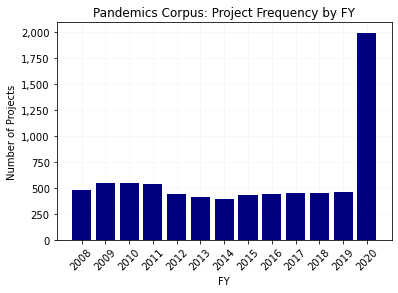

In [63]:
# distribution of abstracts over time
year_counts = df["FY"].value_counts().sort_index()

# plot
year = year_counts.index.tolist()
count = year_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
plt.xticks(year, rotation=45)
#plt.xlim(2007.3,2020.7)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.xlabel("FY")
plt.ylabel("Number of Projects")
plt.title("Pandemics Corpus: Project Frequency by FY");
plt.savefig("pand_dist_time.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/pan_startyr_freq.pdf", dpi = 800, bbox_inches = "tight")

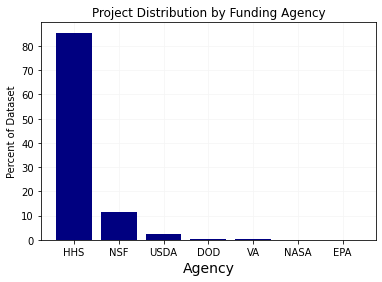

In [64]:
# distribution of abstracts across agency
agency_counts = df["DEPARTMENT"].value_counts()
agency = agency_counts.index.tolist()
pct = 100*agency_counts.values/len(df)

#reload(plt)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(agency, pct, color='navy')
#plt.xticks(agency, rotation=45)
plt.xlabel("Agency", fontsize = 14)
plt.ylabel("Percent of Dataset", fontsize = 10)
plt.title("Project Distribution by Funding Agency");

plt.savefig("pan_dist_agency.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/OECD/pan_agency_dist.pdf", dpi = 800, bbox_inches = "tight")

# 2. Dynamic NMF

In [65]:
# set the parameters
path = '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/pandemics_dnmf_k_topics/five_topics/term_docs/Term_docs_'
n_topics = list(range(5,35,5))   #[5]

# First stage
(windows_topic, windows_coherence, windows_topic_list, windows_W, windows_H, windows_terms) = first_stage(path, year, n_topics, dictionary, docs)

# Second stage
(M, all_terms, topics_list, W_list, H_list) = second_stage(windows_H, windows_terms, n_topics)

# Compute the coherence for the second stage
coherence = []
for t in range(0,len(n_topics)):
    window_term_rankings = topics_list[t]
    cm = CoherenceModel(topics=window_term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', topn=10, processes=30)
    coherence.append(cm.get_coherence())
    
# best model: we only have number of topics
max_coherence = numpy.nanmax(coherence)
index = coherence.index(max_coherence)
topic_select = n_topics[index]
topic_list = topics_list[index]
W = W_list[index]
H = H_list[index]
print('The best number of topics: '+str(topic_select))

--- windows topic 2008 solve ---
--- windows topic 2009 solve ---
--- windows topic 2010 solve ---
--- windows topic 2011 solve ---
--- windows topic 2012 solve ---
--- windows topic 2013 solve ---
--- windows topic 2014 solve ---
--- windows topic 2015 solve ---
--- windows topic 2016 solve ---
--- windows topic 2017 solve ---
--- windows topic 2018 solve ---
--- windows topic 2019 solve ---
--- windows topic 2020 solve ---
--- Dynamic nmf: first stage clear ---
--- New document-terms have been created ---
--- Dynamic nmf: second stage clear ---
The best number of topics: 25


In [67]:
# First stage output
df_firststage = pd.DataFrame(list(zip(year, windows_topic, windows_coherence)),
               columns =['Year', 'Number_topics','Topic_coherence'])
df_firststage

,Year,Number_topics,Topic_coherence
0,2008,10,0.625775
1,2009,30,0.608189
2,2010,25,0.648488
3,2011,20,0.640006
4,2012,25,0.625988
5,2013,25,0.650409
6,2014,20,0.657496
7,2015,20,0.667027
8,2016,10,0.642355
9,2017,10,0.630085


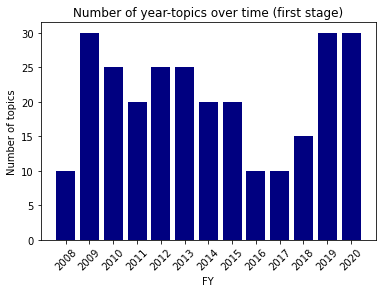

In [69]:
# Number of yearly topics over time
topic_windows_ts = pd.Series(windows_topic, index =year)
plt.bar(year,windows_topic, color='navy')
plt.title('Number of year-topics over time (first stage)')
plt.xlabel("FY")
plt.xticks(year, rotation=45)
plt.ylabel("Number of topics")
plt.savefig('first_stage_number_topics.png')

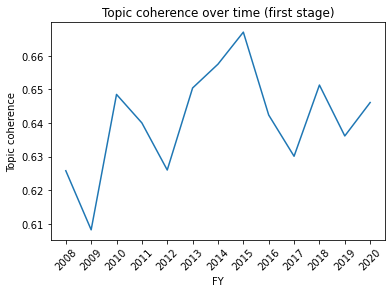

In [70]:
coherence_windows_ts = pd.Series(windows_coherence, index =year)
plt.plot(coherence_windows_ts)
plt.title('Topic coherence over time (first stage)')
plt.xlabel("FY")
plt.xticks(year, rotation=45)
plt.ylabel("Topic coherence")
plt.savefig('first_stage_max_coherence.png')

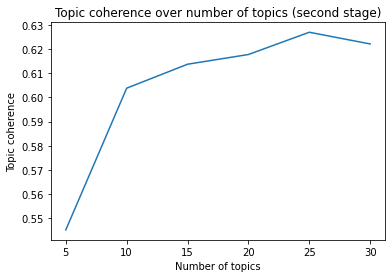

In [71]:
# Plot the coherence
coherence_ts = pd.Series(coherence, index =n_topics)
plt.plot(coherence_ts)
plt.title('Topic coherence over number of topics (second stage)')
plt.xlabel("Number of topics")
plt.ylabel("Topic coherence")
plt.savefig('second_stage_range_coherence.png')

In [72]:
# Print the list of topics
pandemic_dnmf = []

for i in range(0,len(topic_list)):
    print(topic_list[i])
    
# Save the overall list of topics as dataframe
overall = pd.DataFrame(topic_list, index=["Topic"+" "+str(i) for i in range(0,topic_select)])
overall = overall.transpose()

['influenza', 'vaccination', 'strain', 'effectiveness', 'ha', 'age', 've', 'household', 'estimate', 'universal']
['virus', 'human', 'animal', 'host', 'viral', 'evolution', 'genetic', '1918', 'disease', 'transmission']
['hiv', 'aids', 'prevention', 'trial', 'intervention', 'treatment', 'clinical', 'microbicide', 'woman', 'art']
['vaccine', 'protective', 'attenuate', 'adjuvant', 'efficacy', 'candidate', 'protection', 'strain', 'rsv', 'response']
['hiv_1', 'env', 'subtype', 'glycan', 'transmission', 'shiv', 'infection', 'recombinant', 'bnabs', 'sexual']
['cell', 'response', 'memory', 'lung', 'cd4', 'infection', 'immunity', 'immune', 'cd8', 'subset']
['risk', 'public', 'behavior', 'health', 'perception', 'information', 'policy', 'survey', 'response', 'people']
['training', 'program', 'trainee', 'student', 'faculty', 'infectious', 'university', 'health', 'disease', 'train']
['iav', 'lung', 'host', 'response', 'mast', 'infection', 'sp', 'evolution', 'mmp_9', 'evade']
['protection', 'immune',

In [73]:
# Save the result of all topic
pandemic_dnmf = []
#pandemic_dnmf.append(overall)
assign_topics = []

# Save all the output in a list of dataframe
for topic in range(0,topic_select):
    (df,assign) = track_dynamic(topic,W,windows_topic_list,windows_topic)
    
    # save the output
    pandemic_dnmf.append(df)
    assign_topics.append(assign)

In [74]:
# list of topics 
overall.transpose()

,0,1,2,3,4,5,6,7,8,9
Topic 0,influenza,vaccination,strain,effectiveness,ha,age,ve,household,estimate,universal
Topic 1,virus,human,animal,host,viral,evolution,genetic,1918,disease,transmission
Topic 2,hiv,aids,prevention,trial,intervention,treatment,clinical,microbicide,woman,art
Topic 3,vaccine,protective,attenuate,adjuvant,efficacy,candidate,protection,strain,rsv,response
Topic 4,hiv_1,env,subtype,glycan,transmission,shiv,infection,recombinant,bnabs,sexual
Topic 5,cell,response,memory,lung,cd4,infection,immunity,immune,cd8,subset
Topic 6,risk,public,behavior,health,perception,information,policy,survey,response,people
Topic 7,training,program,trainee,student,faculty,infectious,university,health,disease,train
Topic 8,iav,lung,host,response,mast,infection,sp,evolution,mmp_9,evade
Topic 9,protection,immune,ecologic,pathogenicity,environmental,evolution,correlate,influence,animal,emergence


In [75]:
# change in topics 0
pandemic_dnmf[2]

,2008 [0],2009 [0],2009 [1],2010 [0],2011 [0],2012 [0],2012 [1],2013 [0],2014 [0],2015 [0],2016 [0],2017 [0],2018 [0],2019 [0],2020 [0]
0,hiv,hiv,microbicide,hiv,hiv,hiv,cd4,hiv,hiv,hiv,hiv,hiv,hiv,hiv,hiv
1,aids,aids,hsv,aids,aids,aids,aptamer,aids,aids,aids,aids,aids,aids,prevention,aids
2,microbicide,man,hiv,microbicide,trial,infection,sirna,trial,intervention,prevention,clinical,clinical,prevention,aids,prevention
3,risk,trial,hsv_2,trial,microbicide,woman,chimera,woman,woman,trial,prevention,art,cure,cure,pwid
4,trial,risk,safety,risk,woman,semen,hiv,intervention,prevention,adherence,drug,drug,cell,trial,cure
5,intervention,treatment,combination,woman,intervention,trial,ccr5,infection,trial,treatment,network,tb,antiretroviral,therapy,hiv_1
6,clinical,individual,sustained,intervention,risk,infect,microbicide,infect,treatment,network,art,prevention,clinical,clinical,art
7,incidence,ctu,acyclovir,individual,prevention,increase,silence,activation,investigator,clinical,adherence,infect,therapy,treatment,antiretroviral
8,man,intervention,transmission,prevention,infection,viremia,transmission,prevention,economic,tb,trial,treatment,treatment,eradication,meth
9,prevention,infect,genital_herpe,transmission,individual,risk,rna,viremia,incidence,intervention,infect,siv,art,art,cd4


In [16]:
# save the dynamic topic model
Excelwriter = pd.ExcelWriter("Pandemic_dynamic_nmf.xlsx", engine="xlsxwriter")

#We now we'll loop the list of dataframes
for i, df in enumerate (pandemic_dnmf):
    df.to_excel(Excelwriter, sheet_name="Topic" + str(i),index=False)
    
#And finally we save the file
Excelwriter.save()

# 3. Compute the topic weigth over time 

In [76]:
# Step to compute the topics importance over time
rowid = [i for i in range(0, sum(windows_topic))]
rowiter = iter(rowid)
window_row = [list(islice(rowiter, elem)) for elem in windows_topic]
topic_weight = []
doc_count = []

for t in range(0,len(year)):
    # step 1: subset the W matrix to the windows-topics at time t.
    W_hat = W[window_row[t],]
    
    # step 2: use the documents-windows topics at t, and compute the adjusted windows topics
    W_adj = numpy.dot((windows_W[t]),W_hat)
    
    # Compute the general topics importance at time t
    dfW = pd.DataFrame(W_adj, columns=["Topic"+" "+str(i) for i in range(0,topic_select)])
    #dfW_bool = (dfW > 0)
    #total = dfW_bool.sum()
    total = dfW.count()
    weigth = dfW.sum()
    importance = weigth/total
    
    # save the result
    topic_weight.append(importance)
    doc_count.append(total)
    

In [77]:
# 4.1. Use the variation from the main topic
bin_change = []
content = []
content1 = []

for k in range(0,topic_select):
    trend = []
    trend1 = []
    trend2 = []
    for t in range(0,len(assign_topics[k])):
        if (len(assign_topics[k][t])==0):
            dist=0
            dist1=0
            change = 0
        else:
            # use euclidian distance
            dist1=numpy.mean([sum(numpy.square(((M[assign_topics[k][t][i],]) - (H[k,])).tolist())) for i in range(0,len(assign_topics[k][t]))])
            # use cosine similarity distance
            dist=numpy.mean( [1-cosine_similarity( numpy.array([(M[assign_topics[k][t][i],]).tolist()]) , numpy.array([(H[k,]).tolist()]) )[0][0] for i in range(0,len(assign_topics[k][t]))])
            # capture the changes
            change = 1
        trend.append(dist)
        trend1.append(dist1)
        trend2.append(change)
    content.append(trend)
    content1.append(trend1)
    bin_change.append(trend2)

In [78]:
# topic year
yearlist = (numpy.repeat(year,topic_select)).tolist()

# topic number
topicnum = []
for t in year:
    topicnum.append([i for i in range(0,topic_select)])

topicnum = sum(topicnum,[])

# topic importance
topic_import = [item for j in range(0,len(year)) for item in topic_weight[j]]
topic_docs = [item for j in range(0,len(year)) for item in doc_count[j]]

# topic content: cosine
temp0 = numpy.transpose(numpy.array(content))
cosin = sum(temp0.tolist(),[])

# topic content: euclide
temp0 = numpy.transpose(numpy.array(content1))
euclide = sum(temp0.tolist(),[])

# content changes: 
temp0 = numpy.transpose(numpy.array(bin_change))
change = sum(temp0.tolist(),[])

# create the dataframe
dfmodel = pd.DataFrame(list(zip(yearlist, topicnum, topic_import, topic_docs, cosin, euclide,change)),
               columns =['year', 'topic_num','importance','docs','cosine','euclide','change'])

In [79]:
# topic names
topic_name=["Topic"+" "+str(i+1) for i in range(0,topic_select)]

# compute the correlation importance and new idea over time
corr1 = []
corr2 = []
corr3 = []
corr4 = []
mean = []
sd = []

for num in range(0,topic_select):
    subset = dfmodel[dfmodel['topic_num']==num]
    subset['cosine_1'] = subset['cosine'].shift(1)
    r1 = ma.corrcoef(ma.masked_invalid(subset['importance']), ma.masked_invalid(subset['cosine']) )
    r2 = ma.corrcoef(ma.masked_invalid(subset['importance']), ma.masked_invalid(subset['cosine_1']) )
    r3 = ma.corrcoef(ma.masked_invalid(subset['docs']), ma.masked_invalid(subset['cosine']) )
    r4 = ma.corrcoef(ma.masked_invalid(subset['docs']), ma.masked_invalid(subset['cosine_1']) )
    rmean = ma.mean(ma.masked_invalid(subset['importance']))
    rsd = ma.std(ma.masked_invalid(subset['importance']))
    corr1.append(round(r1[0,1],2))
    corr2.append(round(r2[0,1],2))
    corr3.append(round(r3[0,1],2))
    corr4.append(round(r4[0,1],2))
    mean.append(round(rmean,4))
    sd.append(round(rsd,4))

dfcorr = pd.DataFrame(list(zip(topic_name,corr1, corr2, corr3, corr4, mean, sd)),
                       columns =['topic_name', 'corr1','corr2','corr3','corr4', 'mean','sd'])

Text(0.5, 1.0, 'Change in content and the number of grants')

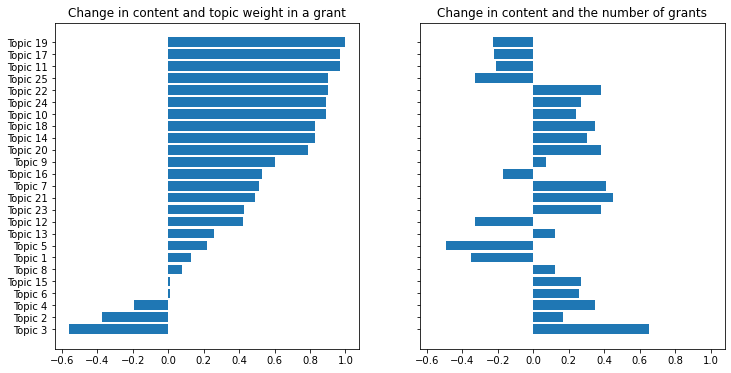

In [80]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize=(12,6))

#plt.figure(figsize=(6,6))
dfcorr1 = dfcorr.sort_values(by=['corr1'])
ax[0].barh(dfcorr1['topic_name'],dfcorr1['corr1'])
ax[0].set_title('Change in content and topic weight in a grant')

ax[1].barh(dfcorr1['topic_name'],dfcorr1['corr3'])
ax[1].set_title('Change in content and the number of grants')

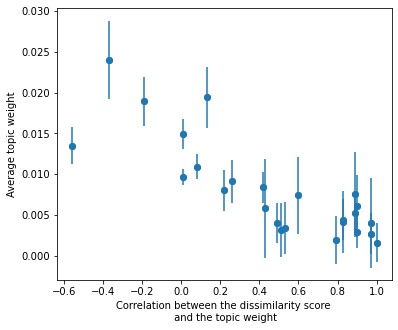

In [81]:
plt.figure(figsize=(6,5))
plt.scatter(dfcorr1['corr1'],dfcorr1['mean'])
plt.errorbar(dfcorr1['corr1'],dfcorr1['mean'], yerr=dfcorr1['sd'], fmt="o")
plt.xlabel('Correlation between the dissimilarity score \n and the topic weight')
plt.ylabel('Average topic weight')

plt.show()

In [82]:
dfcorr2 = dfcorr1.sort_values(by=['mean'])
dfcorr2

,topic_name,corr1,corr2,corr3,corr4,mean,sd
18,Topic 19,1.00,0.58,-0.23,-0.29,0.0016,0.0024
19,Topic 20,0.79,0.48,0.38,0.49,0.0019,0.0029
10,Topic 11,0.97,-0.09,-0.21,0.32,0.0027,0.0025
21,Topic 22,0.90,0.30,0.38,-0.23,0.0029,0.0020
6,Topic 7,0.51,0.47,0.41,0.46,0.0031,0.0033
15,Topic 16,0.53,0.11,-0.17,-0.21,0.0034,0.0032
20,Topic 21,0.49,0.40,0.45,0.53,0.0040,0.0024
16,Topic 17,0.97,0.66,-0.22,0.42,0.0040,0.0055
17,Topic 18,0.83,0.04,0.35,0.34,0.0041,0.0038
13,Topic 14,0.83,0.62,0.30,-0.31,0.0044,0.0025


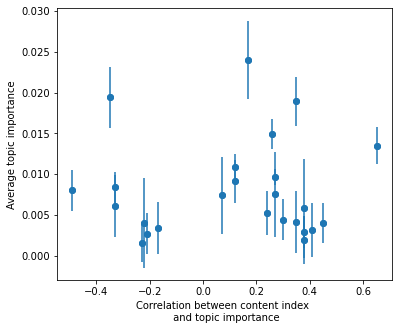

In [83]:
plt.figure(figsize=(6,5))
plt.scatter(dfcorr1['corr3'],dfcorr1['mean'])
plt.errorbar(dfcorr1['corr3'],dfcorr1['mean'], yerr=dfcorr1['sd'], fmt="o")
plt.xlabel('Correlation between content index \n and topic importance')
plt.ylabel('Average topic importance')
    
plt.show()

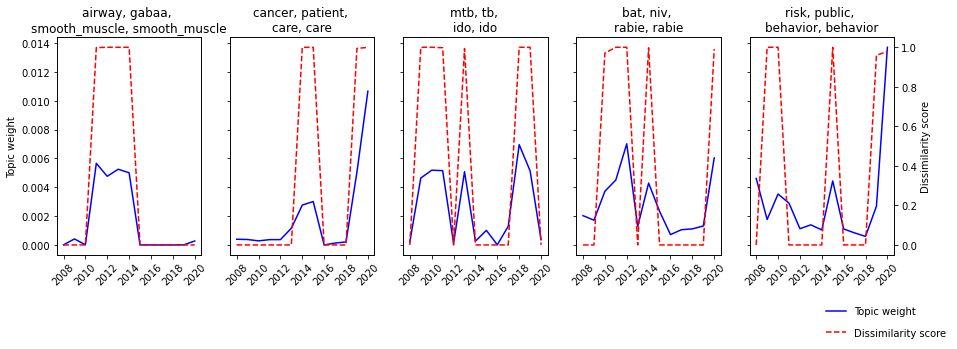

In [84]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(1, 5, sharex = True, sharey = True, figsize=(15,4))
#plt.xticks(numpy.arange(2008, 2020, step=5), rotation =45)
highcorr = [18, 19, 10, 21, 6]

for p in range(0,len(highcorr)):
    subset = dfmodel[dfmodel['topic_num']==highcorr[p]]

    ax2 = ax[p].twinx()
    # make a plot
    ax[p].plot(subset['year'], subset['importance'], "-",color="blue")
    ax2.plot(subset['year'], subset['cosine'], "--", color="red" )
    ax[p].set_xticks(subset['year'][::2])
    ax[p].set_xticklabels(subset['year'][::2], rotation=45)
    ax[p].set_title(overall['Topic '+str(highcorr[p])][0] +', '+ overall['Topic '+str(highcorr[p])][1] +', \n'+ overall['Topic '+str(highcorr[p])][2] +', '+ overall['Topic '+str(highcorr[p])][2])
    if(p!=4):
        ax2.tick_params(top=False, labeltop=False, right=False, labelright=False)
    if(p==0):
        ax[p].set_ylabel('Topic weight')
    if(p==4):
        ax2.set_ylabel('Dissimilarity score')
        ax[p].legend(['Topic weight'], loc='lower left', bbox_to_anchor=(0.5,-0.3), ncol=1, borderaxespad=0, frameon=False)
        ax2.legend(['Dissimilarity score'], loc='lower left', bbox_to_anchor=(0.5,-0.4), ncol=1, borderaxespad=0, frameon=False)
    
#labels = ['v1', 'v2']
#fig.legend(labels, loc='lower right', bbox_to_anchor=(0.5,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
plt.show()    

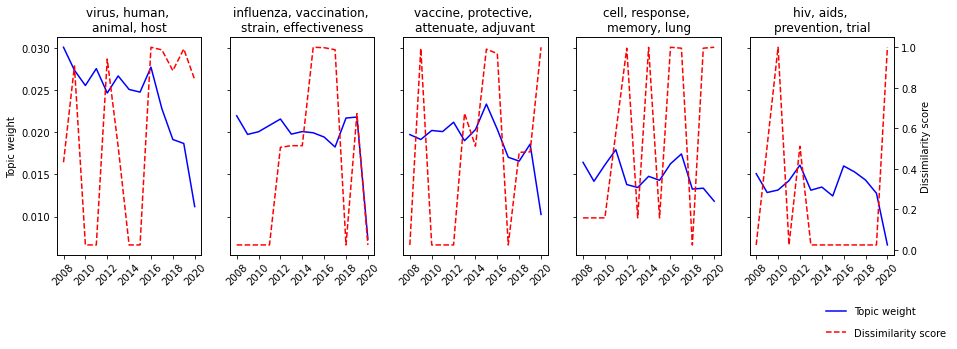

In [85]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(1, 5, sharex = True, sharey = True, figsize=(15,4))
lowcorr = [1, 0, 3, 5, 2]

for p in range(0,len(lowcorr)):
    subset = dfmodel[dfmodel['topic_num']==lowcorr[p]]
    ax2 = ax[p].twinx()

    # make a plot
    ax[p].plot(subset['year'], subset['importance'], "-",color="blue")
    ax2.plot(subset['year'], subset['cosine'], "--", color="red" )
    ax[p].set_xticks(subset['year'][::2])
    ax[p].set_xticklabels(subset['year'][::2], rotation=45)
    #ax[p].set_title('Topic'+str(lowcorr[p]))
    ax[p].set_title(overall['Topic '+str(lowcorr[p])][0] +', '+ overall['Topic '+str(lowcorr[p])][1] +', \n'+ overall['Topic '+str(lowcorr[p])][2] +', '+ overall['Topic '+str(lowcorr[p])][3])
    if(p!=4):
        ax2.tick_params(top=False, labeltop=False, right=False, labelright=False)
    if(p==0):
        ax[p].set_ylabel('Topic weight')
    if(p==4):
        ax2.set_ylabel('Dissimilarity score')
        ax[p].legend(['Topic weight'], loc='lower left', bbox_to_anchor=(0.5,-0.3), ncol=1, borderaxespad=0, frameon=False)
        ax2.legend(['Dissimilarity score'], loc='lower left', bbox_to_anchor=(0.5,-0.4), ncol=1, borderaxespad=0, frameon=False)
        
plt.show()    

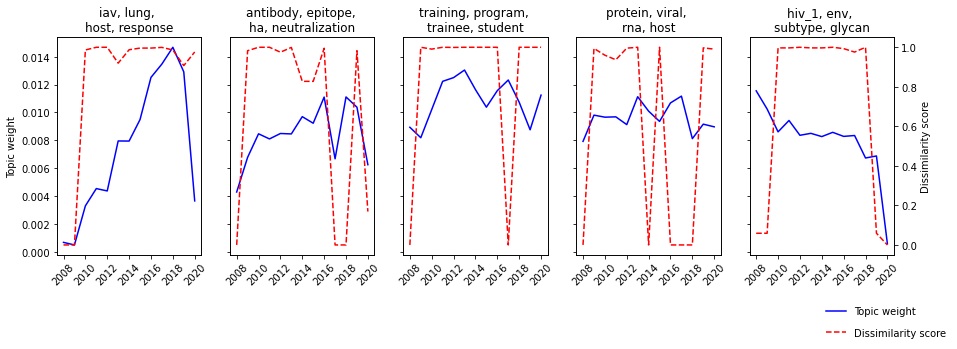

In [86]:
# Topic with a permanent changes in content
fig, ax = plt.subplots(1, 5, sharex = True, sharey = True, figsize=(15,4))
topicid = [8, 11, 7, 14, 4]

for p in range(0,len(topicid)):
    subset = dfmodel[dfmodel['topic_num']==topicid[p]]
    ax2 = ax[p].twinx()

    # make a plot
    ax[p].plot(subset['year'], subset['importance'], "-",color="blue")
    ax2.plot(subset['year'], subset['cosine'], "--", color="red" )
    ax[p].set_xticks(subset['year'][::2])
    ax[p].set_xticklabels(subset['year'][::2], rotation=45)
    #ax[p].set_title('Topic'+str(lowcorr[p]))
    ax[p].set_title(overall['Topic '+str(topicid[p])][0] +', '+ overall['Topic '+str(topicid[p])][1] +', \n'+ overall['Topic '+str(topicid[p])][2] +', '+ overall['Topic '+str(topicid[p])][3])
    if(p!=4):
        ax2.tick_params(top=False, labeltop=False, right=False, labelright=False)
    if(p==0):
        ax[p].set_ylabel('Topic weight')
    if(p==4):
        ax2.set_ylabel('Dissimilarity score')
        ax[p].legend(['Topic weight'], loc='lower left', bbox_to_anchor=(0.5,-0.3), ncol=1, borderaxespad=0, frameon=False)
        ax2.legend(['Dissimilarity score'], loc='lower left', bbox_to_anchor=(0.5,-0.4), ncol=1, borderaxespad=0, frameon=False)
        
plt.show()  

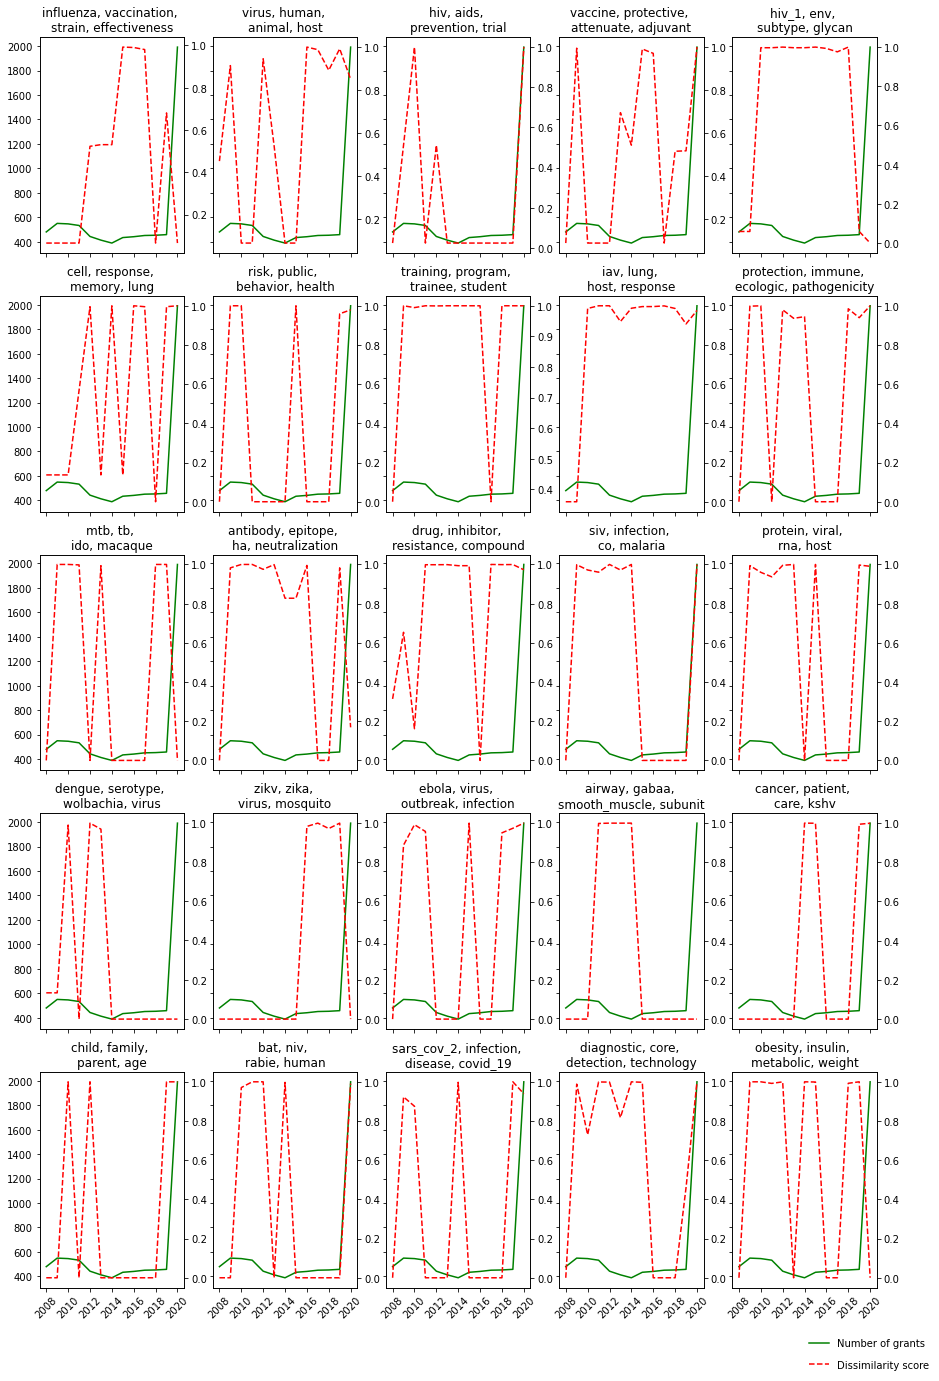

In [104]:
# create figure and axis objects with subplots()
# create figure and axis objects with subplots()
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(15,23))
plt.xticks(rotation ='vertical')

for p in range(0,topic_select):
    subset = dfmodel[dfmodel['topic_num']==p]
    
    # map count to i,j in grid
    i = int(p/5)
    j = p - i*5
    
    ax2 = ax[i,j].twinx()
    # make a plot
    ax[i,j].plot(subset['year'], subset['docs'], "-",color="green")
    ax2.plot(subset['year'], subset['cosine'], "--", color="red" )
    ax[i,j].set_xticks(subset['year'][::2])
    ax[i,j].set_xticklabels(subset['year'][::2], rotation=45)
    #ax[i,j].set_title('Topic'+str(p))
    ax[i,j].set_title(overall['Topic '+str(p)][0] +', '+ overall['Topic '+str(p)][1] +', \n'+ overall['Topic '+str(p)][2] +', '+ overall['Topic '+str(p)][3])

    if (i==4)&(j==4):
        ax[i,j].legend(['Number of grants'], loc='lower left', bbox_to_anchor=(0.5,-0.3), ncol=1, borderaxespad=0, frameon=False)
        ax2.legend(['Dissimilarity score'], loc='lower left', bbox_to_anchor=(0.5,-0.4), ncol=1, borderaxespad=0, frameon=False)
        
#plt.show()
plt.savefig('content_number_grants_all_topics.png')

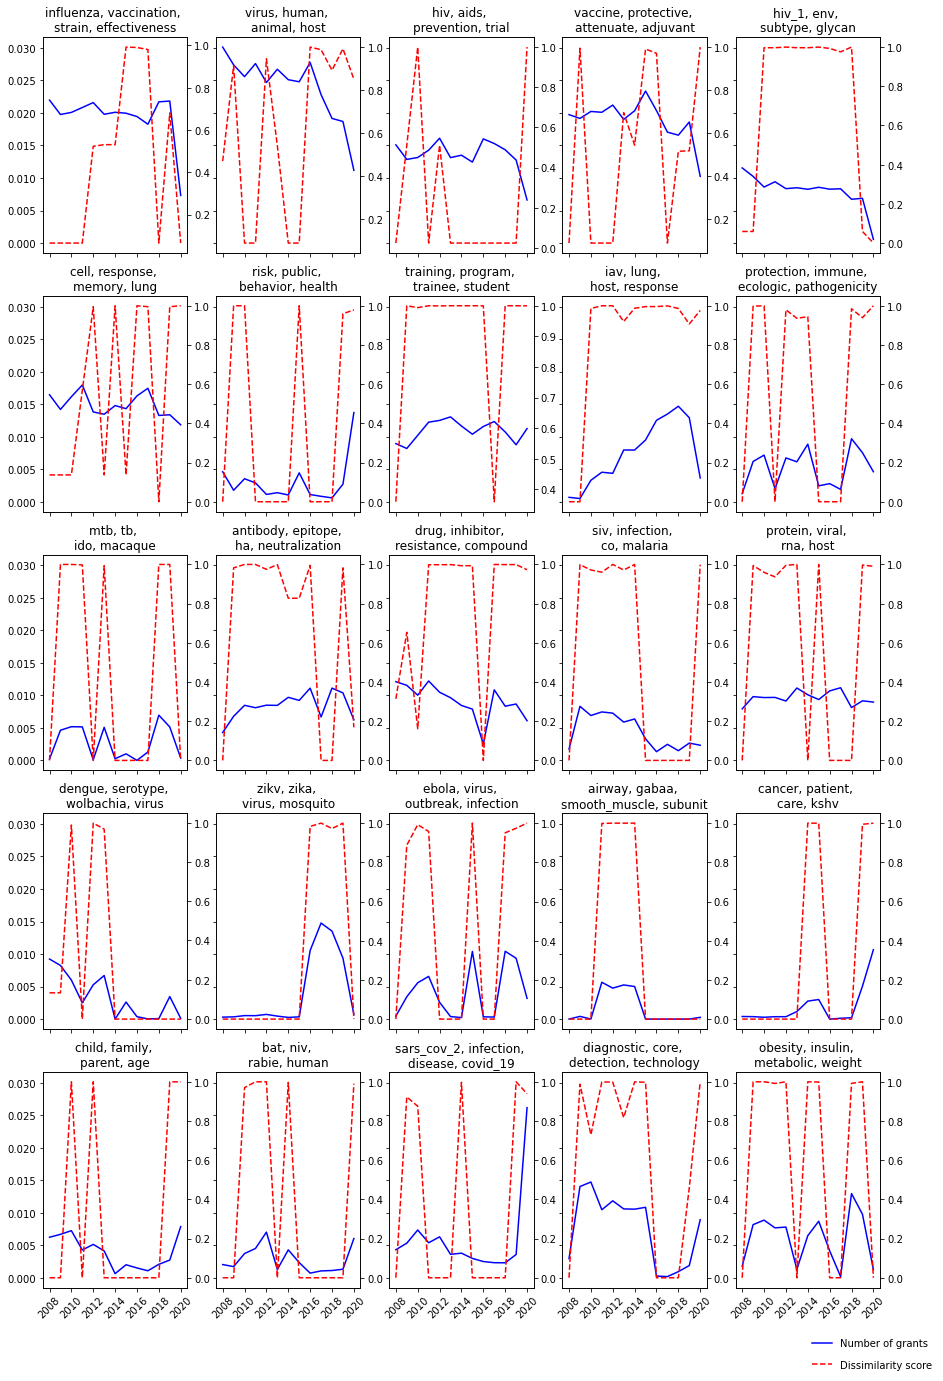

In [102]:
# create figure and axis objects with subplots()
# create figure and axis objects with subplots()
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(15,23))
plt.xticks(rotation ='vertical')

for p in range(0,topic_select):
    subset = dfmodel[dfmodel['topic_num']==p]
    
    # map count to i,j in grid
    i = int(p/5)
    j = p - i*5
    
    ax2 = ax[i,j].twinx()
    # make a plot
    ax[i,j].plot(subset['year'], subset['importance'], "-",color="blue")
    ax2.plot(subset['year'], subset['cosine'], "--", color="red" )
    ax[i,j].set_xticks(subset['year'][::2])
    ax[i,j].set_xticklabels(subset['year'][::2], rotation=45)
    ax[i,j].set_title(overall['Topic '+str(p)][0] +', '+ overall['Topic '+str(p)][1] +', \n'+ overall['Topic '+str(p)][2] +', '+ overall['Topic '+str(p)][3])
    
    if (i==4)&(j==4):
        ax[i,j].legend(['Number of grants'], loc='lower left', bbox_to_anchor=(0.5,-0.3), ncol=1, borderaxespad=0, frameon=False)
        ax2.legend(['Dissimilarity score'], loc='lower left', bbox_to_anchor=(0.5,-0.4), ncol=1, borderaxespad=0, frameon=False)
    
#plt.show()   
plt.savefig('content_topicweight_all_topics.png')

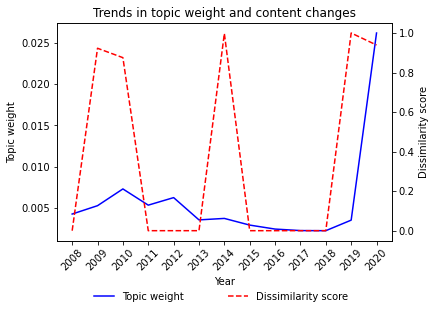

In [52]:
# case study: topic 22
subset = dfmodel[dfmodel['topic_num']==22]

# make a plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = ax.twinx()
ax.plot(subset['year'], subset['importance'], "-",color="blue")
ax1.plot(subset['year'], subset['cosine'], "--", color="red" )
ax.set_xlabel('Year')
ax.set_ylabel('Topic weight')
ax1.set_ylabel('Dissimilarity score')
ax.set_xticklabels(subset['year'], rotation=45)
ax.set_title('Trends in topic weight and content changes')
ax.legend(['Topic weight'], loc='lower left', bbox_to_anchor=(0.1,-0.3), ncol=1, borderaxespad=0, frameon=False)
ax1.legend(['Dissimilarity score'], loc='lower left', bbox_to_anchor=(0.5,-0.3), ncol=1, borderaxespad=0, frameon=False)

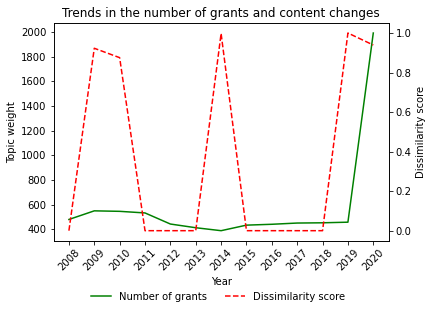

In [53]:
# case study: topic 22
# make a plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = ax.twinx()
ax.plot(subset['year'], subset['docs'], "-",color="green")
ax1.plot(subset['year'], subset['cosine'], "--", color="red" )
ax.set_xlabel('Year')
ax.set_ylabel('Topic weight')
ax1.set_ylabel('Dissimilarity score')
ax.set_xticklabels(subset['year'], rotation=45)
ax.set_title('Trends in the number of grants and content changes')
ax.legend(['Number of grants'], loc='lower left', bbox_to_anchor=(0.1,-0.3), ncol=1, borderaxespad=0, frameon=False)
ax1.legend(['Dissimilarity score'], loc='lower left', bbox_to_anchor=(0.5,-0.3), ncol=1, borderaxespad=0, frameon=False)

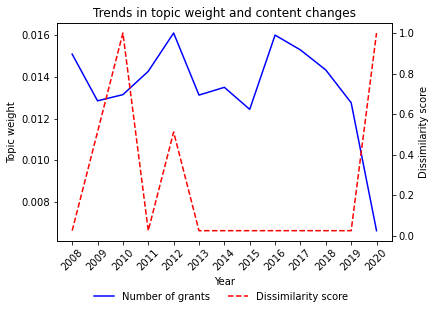

In [54]:
# case study: topic 22
subset = dfmodel[dfmodel['topic_num']==2]

# make a plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = ax.twinx()
ax.plot(subset['year'], subset['importance'], "-",color="blue")
ax1.plot(subset['year'], subset['cosine'], "--", color="red" )
ax.set_xlabel('Year')
ax.set_ylabel('Topic weight')
ax1.set_ylabel('Dissimilarity score')
ax.set_xticklabels(subset['year'], rotation=45)
ax.set_title('Trends in topic weight and content changes')
ax.legend(['Number of grants'], loc='lower left', bbox_to_anchor=(0.1,-0.3), ncol=1, borderaxespad=0, frameon=False)
ax1.legend(['Dissimilarity score'], loc='lower left', bbox_to_anchor=(0.5,-0.3), ncol=1, borderaxespad=0, frameon=False)

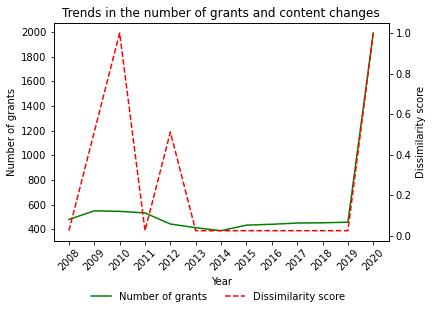

In [55]:
# make a plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = ax.twinx()
ax.plot(subset['year'], subset['docs'], "-",color="green")
ax1.plot(subset['year'], subset['cosine'], "--", color="red" )
ax.set_xlabel('Year')
ax.set_ylabel('Number of grants')
ax1.set_ylabel('Dissimilarity score')
ax.set_xticklabels(subset['year'], rotation=45)
ax.set_title('Trends in the number of grants and content changes')
ax.legend(['Number of grants'], loc='lower left', bbox_to_anchor=(0.1,-0.3), ncol=1, borderaxespad=0, frameon=False)
ax1.legend(['Dissimilarity score'], loc='lower left', bbox_to_anchor=(0.5,-0.3), ncol=1, borderaxespad=0, frameon=False)

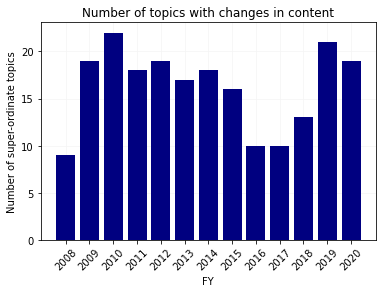

In [30]:
# Trends in the change in the contents 
count = dfmodel.groupby(['year'])['change'].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
plt.xticks(year, rotation=45)
#plt.xlim(2007.3,2020.7)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.xlabel("FY")
plt.ylabel("Number of super-ordinate topics")
plt.title("Number of topics with changes in content");
plt.savefig("number_topic_change.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/pan_startyr_freq.pdf", dpi = 800, bbox_inches = "tight")

Text(0, 0.5, 'Dissimilarity in the content change')

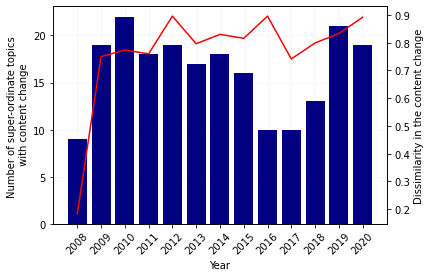

In [44]:
# average number of 
count = dfmodel.groupby(['year'])['change'].sum()
mean = dfmodel[dfmodel['cosine']>0].groupby(['year'])['cosine'].mean()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)

ax.grid(True, color = "whitesmoke")
ax.bar(year, count, color='navy')
ax.set_xticklabels(year, rotation=45)
ax.set_ylabel('Number of super-ordinate topics \n with content change')
ax.set_xlabel('Year')

ax1 = ax.twinx()
ax1.plot(year, mean, "-", color="red" )
ax1.set_ylabel('Dissimilarity in the content change')

#plt.savefig("number_topic_change.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/pan_startyr_freq.pdf", dpi = 800, bbox_inches = "tight")

Text(0.5, 0, 'Year')

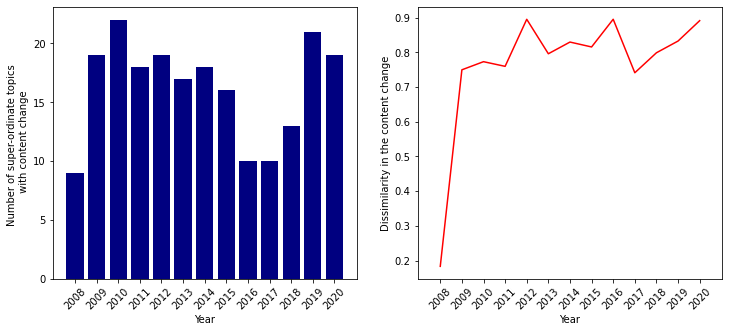

In [51]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey = False, figsize=(12,5))
count = dfmodel.groupby(['year'])['change'].sum()
mean = dfmodel[dfmodel['cosine']>0].groupby(['year'])['cosine'].mean()

#plt.figure(figsize=(6,6))
dfcorr1 = dfcorr.sort_values(by=['corr1'])
ax[0].bar(year, count, color='navy')
ax[0].set_xticklabels(year, rotation=45)
ax[0].set_ylabel('Number of super-ordinate topics \n with content change')
ax[0].set_xlabel('Year')

ax[1].plot(year, mean, "-", color="red" )
ax[1].set_xticklabels(year, rotation=45)
ax[1].set_ylabel('Dissimilarity in the content change')
ax[1].set_xlabel('Year')

# 4. Compute the topic-content change over time

In [26]:
# 4.1. Use the variation from the main topic
content = []
content1 = []

for k in range(0,topic_select):
    trend = []
    trend1 = []
    for t in range(0,len(assign_topics[k])):
        if (len(assign_topics[k][t])==0):
            dist=0
            dist1=0
        else:
            # use euclidian distance
            dist1=numpy.mean([sum(numpy.square(((M[assign_topics[k][t][i],]) - (H[k,])).tolist())) for i in range(0,len(assign_topics[k][t]))])
            # use cosine similarity distance
            dist=numpy.mean( [1-cosine_similarity( numpy.array([(M[assign_topics[k][t][i],]).tolist()]) , numpy.array([(H[k,]).tolist()]) )[0][0] for i in range(0,len(assign_topics[k][t]))]) 
        trend.append(dist)
        trend1.append(dist1)
    content.append(trend)
    content1.append(trend1)

In [27]:
# Dataframe in topic content
df_content = pd.DataFrame(content)
df_content = df_content.transpose()
df_content.columns=["Topic"+" "+str(i) for i in range(0,topic_select)]
df_content['year'] = year

array([[<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>],
       [<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>],
       [<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>],
       [<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>],
       [<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>]], dtype=object)

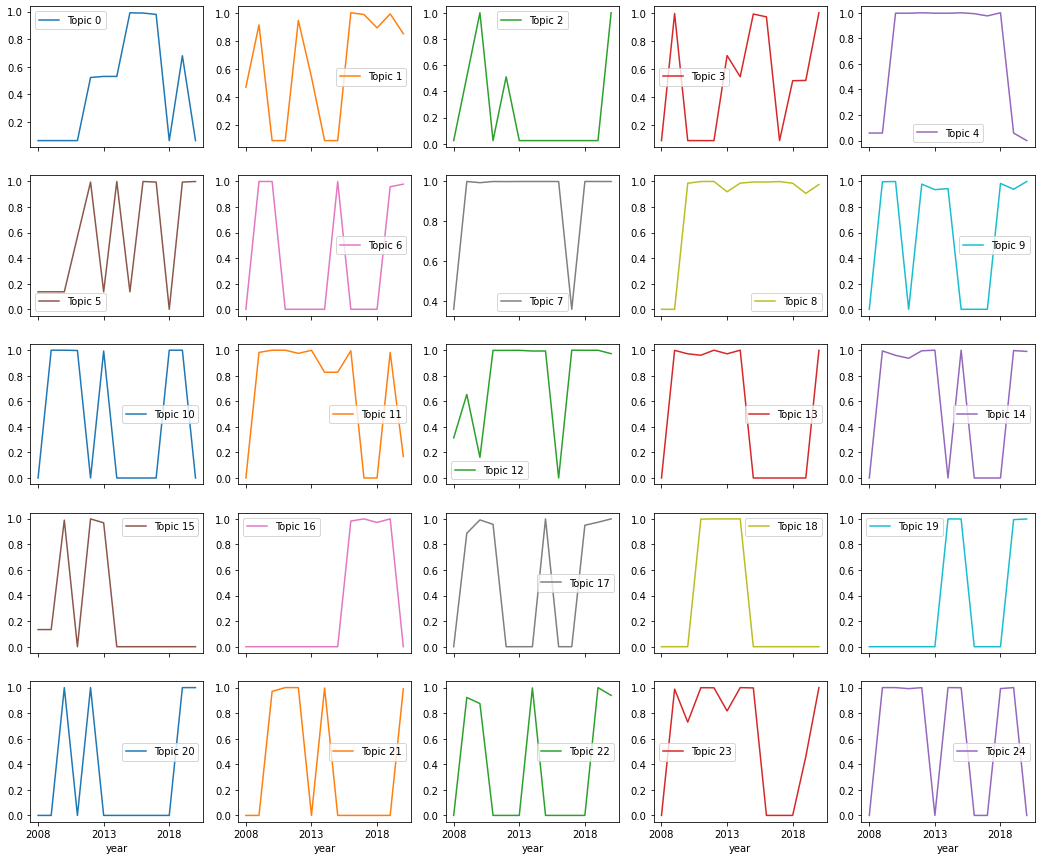

In [28]:
# plot change in topic importance over time
df_content.plot(x='year', subplots=True, layout=(5,5), figsize=(18, 15))

In [29]:
# Dataframe in topic content
df_content1 = pd.DataFrame(content1)
df_content1 = df_content1.transpose()
df_content1.columns=["Topic"+" "+str(i) for i in range(0,topic_select)]
df_content1['year'] = year

array([[<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>],
       [<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>],
       [<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>],
       [<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>],
       [<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>]], dtype=object)

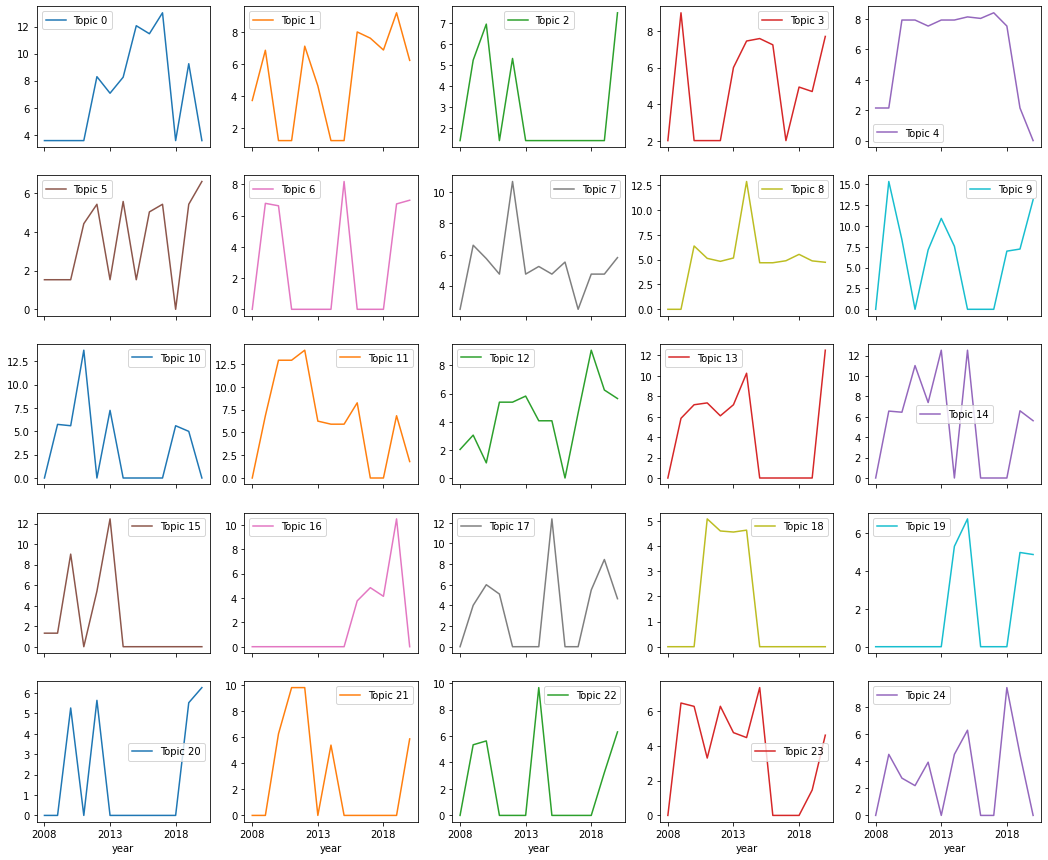

In [30]:
# plot change in topic importance over time
df_content1.plot(x='year', subplots=True, layout=(5,5), figsize=(18, 15))

# 3. Compute the topic importance (method 2)

# 4. Compute the topic content

In [31]:
# list all across time
content = []
content1 = []
weight =[]

for i in range(0,topic_select):
    content.append(df_content.iloc[:,i])
    content1.append(df_content1.iloc[:,i])
    weight.append(df_topicweight.iloc[:,i])
    
weight = [ item for elem in weight for item in elem]
content = [ item for elem in content for item in elem]
content1 = [ item for elem in content1 for item in elem]

<Figure size 432x288 with 0 Axes>

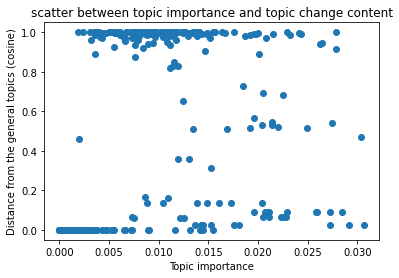

In [32]:
# scatter plot
fig = plt.figure()
fig, ax = plt.subplots()
ax.scatter(weight, content)
plt.xlabel('Topic importance')
plt.ylabel('Distance from the general topics (cosine)')
plt.title('scatter between topic importance and topic change content')
plt.show()

<Figure size 432x288 with 0 Axes>

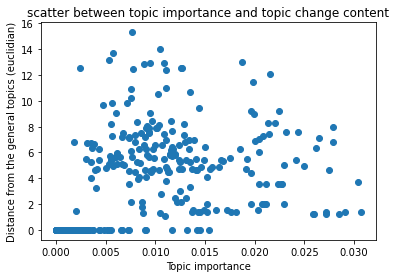

In [33]:
# scatter plot
fig = plt.figure()
fig, ax = plt.subplots()
ax.scatter(weight, content1)
plt.xlabel('Topic importance')
plt.ylabel('Distance from the general topics (euclidian)')
plt.title('scatter between topic importance and topic change content')
plt.show()

# 5. Build the final dataset

In [24]:
fig = plt.figure()

for frame in [df_topicweight, df_content]:
    df_content.plot(x='year', subplots=True, layout=(4,5), figsize=(18, 15))

plt.show()

ValueError: Layout of 4x5 must be larger than required size 25

<Figure size 432x288 with 0 Axes>

<Figure size 1296x1080 with 0 Axes>

In [79]:
window_topic_weigth[[13], [15]]

TypeError: list indices must be integers or slices, not tuple

In [46]:
numpy.ravel(M[assign_topics[0][1][0],]).shape

(940,)

In [60]:
dist = cosine_similarity( numpy.array([(M[assign_topics[0][1][0],]).tolist()]) , numpy.array([(H[0,]).tolist()]) )

In [43]:
array_vec_1 = numpy.array([[12,41,60,11,21]])
array_vec_2 = numpy.array([[40,11,4,11,14]])
print(cosine_similarity(array_vec_1, array_vec_2))

[[0.45227058]]


In [44]:
array_vec_1.shape

(1, 5)

In [61]:
dist

0.5124965268344327